In [7]:
# from network import * 
# from training import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from typing import List, Tuple, Dict, Union, Any, cast
from torch import Tensor
import math
from typing import Any

import torch
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import Module, init
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import torchvision
import torchvision.transforms as transforms
import pickle
import pandas as pd
from multiprocessing import Pool

device = torch.device("cpu")
def plot_parallel_synapse_params(model):
    plt.figure(figsize=(12, 3))
    plt.subplot(1,4,1)
    plt.hist((model.parallel_synapse.ampli.data.cpu().numpy()**2).flatten(), bins=20)
    plt.title('Amplitude histogram')

    plt.subplot(1,4,2)
    plt.hist(model.parallel_synapse.slope.data.cpu().numpy().flatten(), bins=20)
    plt.title('Slope histogram')

    plt.subplot(1,4,3)
    plt.hist(model.parallel_synapse.thres.data.cpu().numpy().flatten(), bins=20)
    plt.title('Threshold histogram')
    
    plt.subplot(1,4,4)
    plt.hist(model.parallel_synapse.scaler.data.cpu().numpy().flatten(), bins=20)
    plt.title('Scaler histogram')
    
    plt.tight_layout()
    plt.show()


def plot_input_histogram_to_parallel_synapse_layer(model, testloader, hidden_act:str = 'sigmoid') -> None:
    '''
    Inputs:
        model: nn.Module
    
    '''
    hidden = []
    final = []
    for inputs, labels in testloader:
        inputs = inputs.view(-1, 28*28)#.to(device)
        
        if hidden_act == 'sigmoid':
            hidden.append(torch.sigmoid(model.fc1(inputs)).detach().cpu())
            
        else:
            hidden.append(torch.relu(model.fc1(inputs)).detach().cpu())
        final.append(model.parallel_synapse(hidden[-1]).detach().cpu())
    hidden = torch.cat(hidden, dim=0)
    hidden = hidden.data.cpu().numpy()
    final = torch.cat(final, dim=0)
    plt.figure(figsize=(9, 3 ))
    plt.subplot(1,3,1)
    plt.hist(hidden[hidden>0.00001].flatten(), bins=100)
    plt.title('Hidden activation, {:.1f}% > 1e-4'.format((hidden>1e-4).mean() * 100))
    plt.legend()
    plt.xlabel('hidden layer input')
    plt.ylabel('count')
    
    f = model.parallel_synapse
    slope = f.slope
    ampli = f.ampli
    thres = f.thres
    input_dim = slope.shape[1]
    n_data = 100
    output_dim = slope.shape[-1]
    input = torch.linspace(0, model.hidden_range[1]*2, steps=n_data).reshape(-1, 1)
    input = input.repeat(1, input_dim)
    n_data = input.shape[0]
    n_synapse = slope.shape[0]
    

    x = slope[None, :, :, :].expand(n_data, n_synapse, input_dim, output_dim) \
        * (input[:, None, :, None].expand(n_data, n_synapse, input_dim, output_dim)
        - thres[None, :, :, :].expand(n_data, n_synapse, input_dim, output_dim))
    x = torch.tanh(x)
    x = x * (ampli[None, :, :, :]**2 ).expand(n_data, n_synapse, input_dim, output_dim)
    # x = x * f.scaler[None, None, :, :].expand(n_data, n_synapse, input_dim, output_dim)
    x = x.sum(dim=1).squeeze() 
    
    
    plt.subplot(1,3,2)
    plt.hist(final.data.cpu().numpy().flatten(), bins=100, label='MNIST')
    ylim = plt.ylim()
    plt.legend()
    plt.xlabel('output')
    plt.title('Histogram, final layer input')
    
    plt.tight_layout() 
    
    plt.figure(figsize = (10, 4))
    
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.plot(input[:,0].numpy(), x.detach().numpy()[:,:,i], alpha = 0.8)
        plt.title('output-' + str(i+1))
        plt.xlabel('Input')
    plt.tight_layout()
    plt.show()

def plot_result(result):
    plt.figure(figsize=(6, 3))
    plt.subplot(1,2,1)
    plt.plot(result['loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(result['accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.tight_layout()
    plt.show()
def train_models_NN(model, 
                trainloader, 
                testloader,
                regularization = 0.0,
                H = 20, 
                in_dim = 28, 
                out_dim = 10, 
                num_epochs = 20,
                verbose = True, 
                device = torch.device('cpu'),
                model_type = 'parallel'): 
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    losses, acc = [], []
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            if model_type == 'parallel':
                with torch.no_grad():
                    slope_thres = 0.01
                    mask = (model.parallel_synapse.slope.data < slope_thres) 
                    model.parallel_synapse.slope.data = torch.clamp(model.parallel_synapse.slope.data, min = slope_thres)
                    model.parallel_synapse.thres.data[mask] = torch.rand(mask.sum()) * model.hidden_range[1] + model.hidden_range[0]
                    
                    ampli_thres = 0.1
                    mask = (model.parallel_synapse.ampli.data**2 < ampli_thres) 
                    model.parallel_synapse.thres.data[mask] = torch.rand(mask.sum()) * model.hidden_range[1] + model.hidden_range[0]
                    model.parallel_synapse.ampli.data[mask] = np.sqrt(ampli_thres)
                    
                    # model.parallel_synapse.thres.data = torch.clamp(model.parallel_synapse.thres.data, min = model.hidden_range[0] )
        
            inputs = inputs.view(-1, 28*28).to(device)
            labels = labels.to(device)
            # labels = oneHotLabel(labels, out_dim).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.nll_loss(outputs, labels) 
            
            # loss = multiHingeLoss(outputs, labels) 
            if model_type == 'parallel':
                loss += regularization * (torch.abs(model.parallel_synapse.scaler) - 1).abs().sum()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        losses.append(running_loss / len(trainloader))
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs = inputs.view(-1, 28*28).to(device)
                labels = labels.to(device)
                
                # labels = oneHotLabel(labels, out_dim).to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                # correct += torch.argmax(outputs, dim = 1).eq(torch.argmax(labels, dim = 1)).sum().item()
        acc.append(100 * correct / total )
        if verbose and epoch % 10 == 0:
            print( f" Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(trainloader):.4f}, Accuracy: {acc[-1]:.2f}%")
            # plot_parallel_synapse_params(model)
            # plot_input_histogram_to_parallel_synapse_layer(model, testloader, hidden_act='relu')
    
    
    return {
            'model': model,
            'accuracy': acc,
            'loss': losses
            }
class ParallelSynapseLayer_FlipSign(nn.Module):
    def __init__(self, 
                input_dim: int, 
                n_synapse: int, 
                output_dim: int, 
                input_range: Tuple = (-1, 1)) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.n_synapse = n_synapse
        self.output_dim = output_dim
        
        self.thres = nn.Parameter(torch.rand(
            self.n_synapse, self.input_dim, self.output_dim) * (input_range[1] - input_range[0]) + input_range[0])
        # normal distribution for threshold
        # self.thres = torch.abs(torch.normal(0, input_range[1] , size=(self.n_synapse, self.input_dim, self.output_dim)) )
        self.slope = nn.Parameter(5*torch.rand(self.n_synapse, self.input_dim, self.output_dim))
        self.ampli = nn.Parameter(torch.rand(self.n_synapse, self.input_dim, self.output_dim))
        self.scaler = nn.Parameter(torch.rand(self.input_dim, self.output_dim))
        
    def forward(self, input: Tensor):
        '''
        Inputs:
            input: (n_data, input_dim)

        Returns:
            output: (n_data, output_dim)
        '''
        n_data = input.shape[0]
        x = self.slope[None, :, :,:].expand(n_data, self.n_synapse, self.input_dim, self.output_dim) * \
            (input[:, None, :, None].expand(n_data, self.n_synapse, self.input_dim, self.output_dim) -
            self.thres[None, :,:,:].expand(n_data, self.n_synapse, self.input_dim, self.output_dim))
        x = (self.ampli[None, :, :,:]**2).expand(n_data, self.n_synapse, self.input_dim, self.output_dim) * \
            torch.tanh(x) 
        x = x.sum(dim=(1)).squeeze()
        x = x * self.scaler[None, :, :].expand(n_data, self.input_dim, self.output_dim)
        x = x.sum(dim=(1)).squeeze() 
        return x

class ParallelSynapse2NN(nn.Module):
    def __init__(self, 
                input_dim: int, 
                n_synapse: int, 
                hidden_dim: int, 
                output_dim: int = 10, 
                hidden_range: Tuple = (0, 40)) -> None:
        super().__init__()
        self.hidden_range = hidden_range
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        
        self.parallel_synapse = ParallelSynapseLayer_FlipSign(hidden_dim, 
                                                n_synapse, 
                                                output_dim, 
                                                input_range = self.hidden_range)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.dropout(x)
        x = self.fc1(x)
        
        # x = nn.LeakyReLU()(x)
        x = torch.relu(x + 20) 
        
        x = self.parallel_synapse(x)
        # return x.squeeze()
        return F.log_softmax(x, dim=1)



In [8]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

hidden_dim = 50
output_dim = 10
input_dim = 28*28

n_synapse = 3
hidden_range = (0, 30)


 Epoch 1/201, Loss: 0.4563, Accuracy: 90.88%
 Epoch 11/201, Loss: 0.1511, Accuracy: 95.44%
 Epoch 21/201, Loss: 0.1161, Accuracy: 96.52%
 Epoch 31/201, Loss: 0.0989, Accuracy: 96.40%
 Epoch 41/201, Loss: 0.0916, Accuracy: 97.03%
 Epoch 51/201, Loss: 0.0822, Accuracy: 96.93%
 Epoch 61/201, Loss: 0.0781, Accuracy: 96.96%
 Epoch 71/201, Loss: 0.0719, Accuracy: 96.80%
 Epoch 81/201, Loss: 0.0712, Accuracy: 97.12%
 Epoch 91/201, Loss: 0.0674, Accuracy: 97.06%
 Epoch 101/201, Loss: 0.0602, Accuracy: 97.43%
 Epoch 111/201, Loss: 0.0622, Accuracy: 97.10%
 Epoch 121/201, Loss: 0.0592, Accuracy: 97.03%
 Epoch 131/201, Loss: 0.0552, Accuracy: 97.35%
 Epoch 141/201, Loss: 0.0536, Accuracy: 97.49%
 Epoch 151/201, Loss: 0.0528, Accuracy: 97.49%
 Epoch 161/201, Loss: 0.0527, Accuracy: 97.49%
 Epoch 171/201, Loss: 0.0489, Accuracy: 97.31%
 Epoch 181/201, Loss: 0.0495, Accuracy: 97.39%
 Epoch 191/201, Loss: 0.0481, Accuracy: 97.53%
 Epoch 201/201, Loss: 0.0478, Accuracy: 97.02%


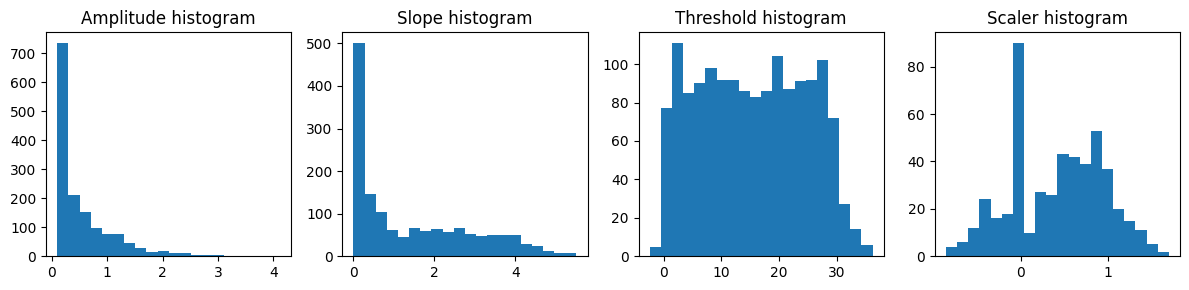

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


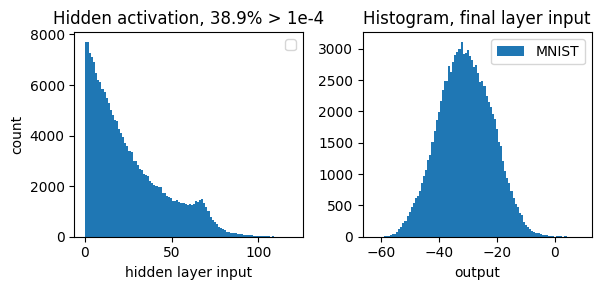

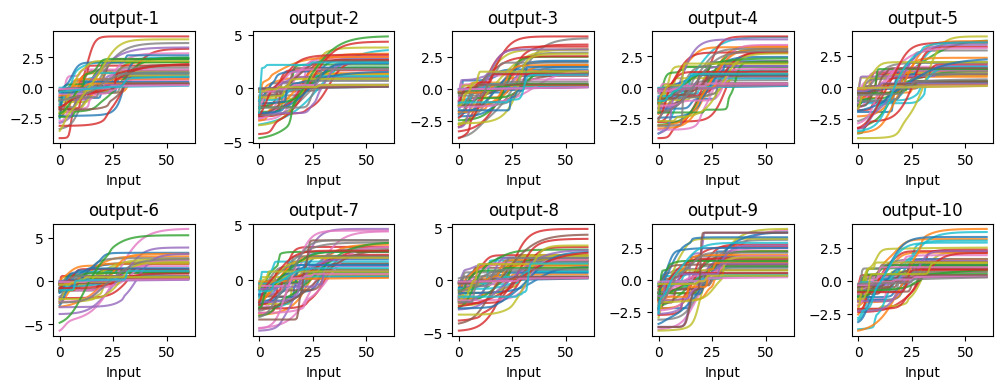

--------------------------------------------------
 Epoch 1/201, Loss: 0.4466, Accuracy: 90.97%
 Epoch 11/201, Loss: 0.1621, Accuracy: 96.14%
 Epoch 21/201, Loss: 0.1228, Accuracy: 96.67%
 Epoch 31/201, Loss: 0.1014, Accuracy: 96.76%
 Epoch 41/201, Loss: 0.0943, Accuracy: 97.00%
 Epoch 51/201, Loss: 0.0830, Accuracy: 97.01%
 Epoch 61/201, Loss: 0.0762, Accuracy: 97.08%
 Epoch 71/201, Loss: 0.0713, Accuracy: 97.45%
 Epoch 81/201, Loss: 0.0685, Accuracy: 97.20%
 Epoch 91/201, Loss: 0.0647, Accuracy: 97.38%
 Epoch 101/201, Loss: 0.0613, Accuracy: 97.02%
 Epoch 111/201, Loss: 0.0588, Accuracy: 97.28%
 Epoch 121/201, Loss: 0.0563, Accuracy: 97.51%
 Epoch 131/201, Loss: 0.0542, Accuracy: 97.54%
 Epoch 141/201, Loss: 0.0537, Accuracy: 97.51%
 Epoch 151/201, Loss: 0.0514, Accuracy: 97.42%
 Epoch 161/201, Loss: 0.0511, Accuracy: 97.31%
 Epoch 171/201, Loss: 0.0501, Accuracy: 97.34%
 Epoch 181/201, Loss: 0.0485, Accuracy: 97.38%
 Epoch 191/201, Loss: 0.0457, Accuracy: 97.57%
 Epoch 201/201, Loss

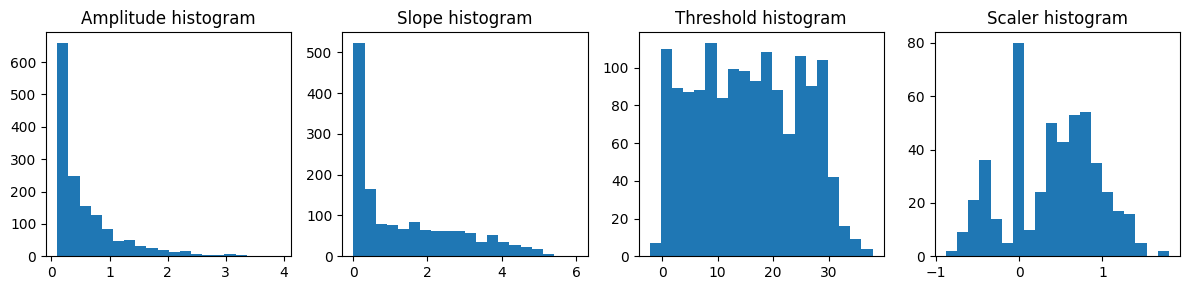

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


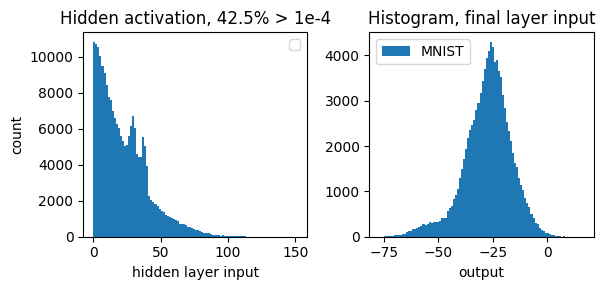

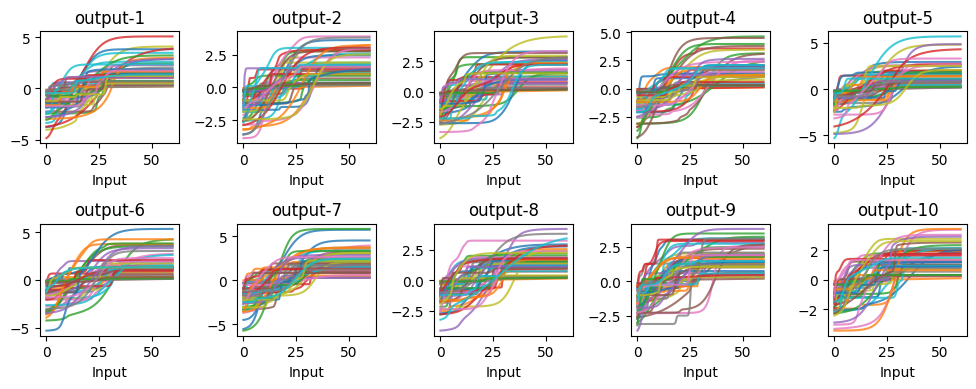

--------------------------------------------------
 Epoch 1/201, Loss: 0.4400, Accuracy: 91.05%
 Epoch 11/201, Loss: 0.1520, Accuracy: 95.30%
 Epoch 21/201, Loss: 0.1182, Accuracy: 96.53%
 Epoch 31/201, Loss: 0.0990, Accuracy: 96.45%
 Epoch 41/201, Loss: 0.0867, Accuracy: 97.01%
 Epoch 51/201, Loss: 0.0787, Accuracy: 97.24%
 Epoch 61/201, Loss: 0.0701, Accuracy: 97.35%
 Epoch 71/201, Loss: 0.0647, Accuracy: 97.13%
 Epoch 81/201, Loss: 0.0646, Accuracy: 97.21%
 Epoch 91/201, Loss: 0.0592, Accuracy: 97.38%
 Epoch 101/201, Loss: 0.0596, Accuracy: 96.96%
 Epoch 111/201, Loss: 0.0538, Accuracy: 97.47%
 Epoch 121/201, Loss: 0.0532, Accuracy: 97.44%
 Epoch 131/201, Loss: 0.0508, Accuracy: 97.45%
 Epoch 141/201, Loss: 0.0511, Accuracy: 97.42%
 Epoch 151/201, Loss: 0.0494, Accuracy: 97.35%
 Epoch 161/201, Loss: 0.0488, Accuracy: 97.58%
 Epoch 171/201, Loss: 0.0466, Accuracy: 97.35%
 Epoch 181/201, Loss: 0.0468, Accuracy: 97.52%
 Epoch 191/201, Loss: 0.0450, Accuracy: 97.18%
 Epoch 201/201, Loss

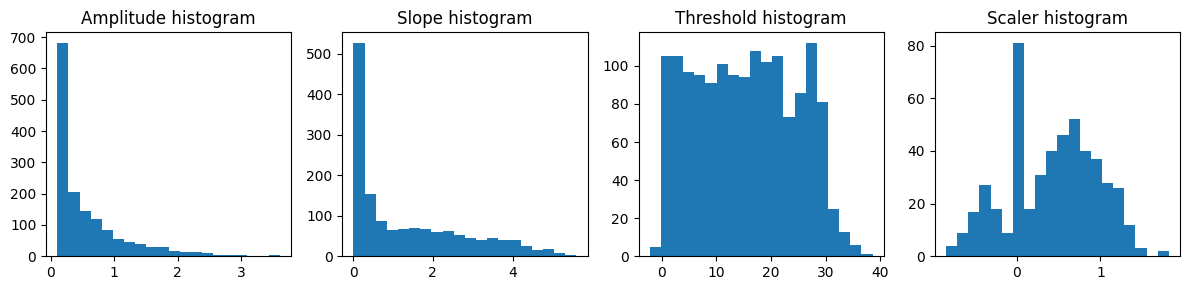

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


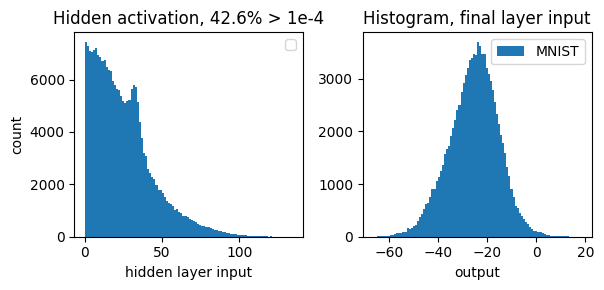

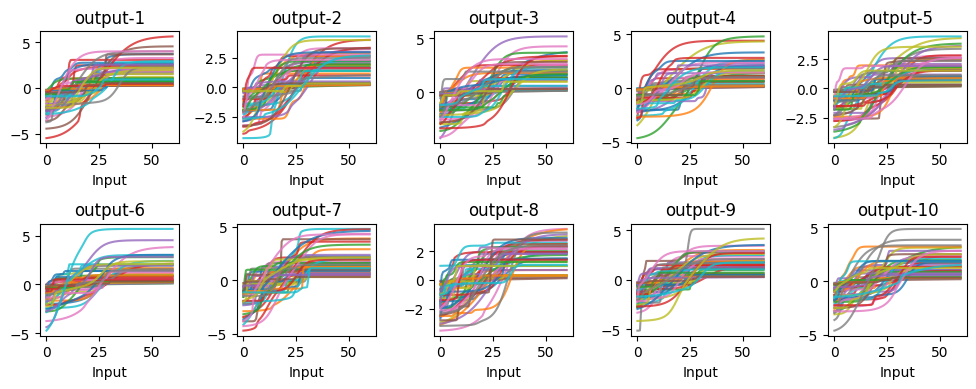

--------------------------------------------------
 Epoch 1/201, Loss: 0.4671, Accuracy: 91.22%
 Epoch 11/201, Loss: 0.1546, Accuracy: 95.95%
 Epoch 21/201, Loss: 0.1181, Accuracy: 96.65%
 Epoch 31/201, Loss: 0.1047, Accuracy: 96.73%
 Epoch 41/201, Loss: 0.0896, Accuracy: 96.95%
 Epoch 51/201, Loss: 0.0833, Accuracy: 96.72%
 Epoch 61/201, Loss: 0.0770, Accuracy: 97.22%
 Epoch 71/201, Loss: 0.0716, Accuracy: 97.20%
 Epoch 81/201, Loss: 0.0705, Accuracy: 97.17%
 Epoch 91/201, Loss: 0.0683, Accuracy: 97.57%
 Epoch 101/201, Loss: 0.0666, Accuracy: 97.13%
 Epoch 111/201, Loss: 0.0633, Accuracy: 97.15%
 Epoch 121/201, Loss: 0.0606, Accuracy: 96.90%
 Epoch 131/201, Loss: 0.0616, Accuracy: 97.14%
 Epoch 141/201, Loss: 0.0597, Accuracy: 97.31%
 Epoch 151/201, Loss: 0.0574, Accuracy: 97.37%
 Epoch 161/201, Loss: 0.0563, Accuracy: 97.39%
 Epoch 171/201, Loss: 0.0538, Accuracy: 97.40%
 Epoch 181/201, Loss: 0.0542, Accuracy: 97.36%
 Epoch 191/201, Loss: 0.0541, Accuracy: 97.40%
 Epoch 201/201, Loss

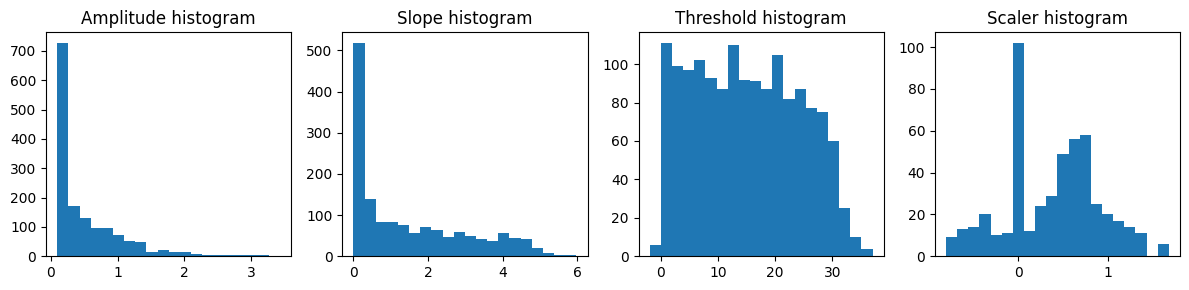

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


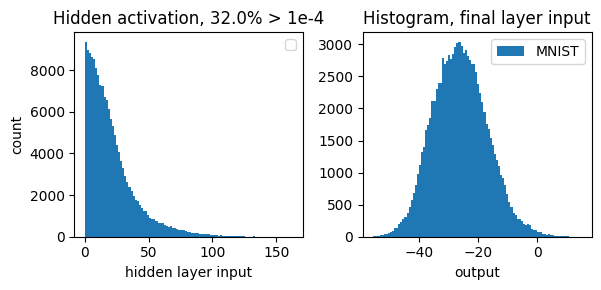

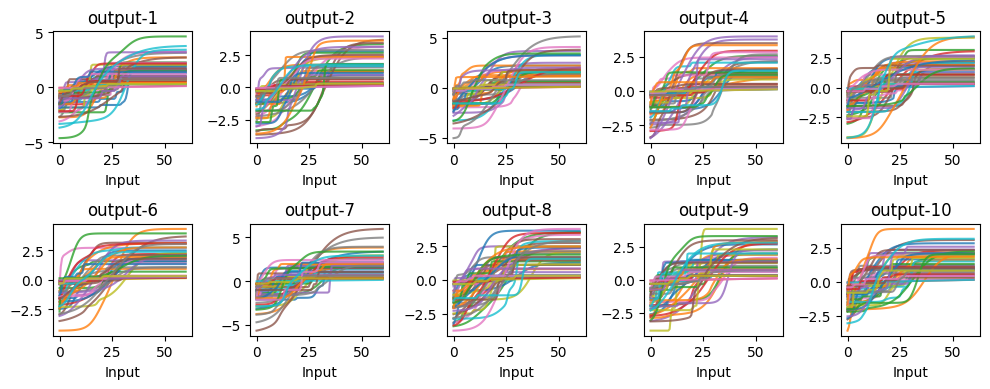

--------------------------------------------------
 Epoch 1/201, Loss: 0.4815, Accuracy: 91.11%
 Epoch 11/201, Loss: 0.1507, Accuracy: 95.81%
 Epoch 21/201, Loss: 0.1161, Accuracy: 96.67%
 Epoch 31/201, Loss: 0.0977, Accuracy: 97.06%
 Epoch 41/201, Loss: 0.0846, Accuracy: 96.97%
 Epoch 51/201, Loss: 0.0754, Accuracy: 97.23%
 Epoch 61/201, Loss: 0.0717, Accuracy: 97.32%
 Epoch 71/201, Loss: 0.0677, Accuracy: 96.83%
 Epoch 81/201, Loss: 0.0631, Accuracy: 97.26%
 Epoch 91/201, Loss: 0.0600, Accuracy: 97.16%
 Epoch 101/201, Loss: 0.0588, Accuracy: 97.36%
 Epoch 111/201, Loss: 0.0533, Accuracy: 97.27%
 Epoch 121/201, Loss: 0.0516, Accuracy: 97.68%
 Epoch 131/201, Loss: 0.0531, Accuracy: 97.49%
 Epoch 141/201, Loss: 0.0491, Accuracy: 97.49%
 Epoch 151/201, Loss: 0.0486, Accuracy: 97.54%
 Epoch 161/201, Loss: 0.0472, Accuracy: 97.30%
 Epoch 171/201, Loss: 0.0470, Accuracy: 97.15%
 Epoch 181/201, Loss: 0.0480, Accuracy: 97.38%
 Epoch 191/201, Loss: 0.0456, Accuracy: 97.50%
 Epoch 201/201, Loss

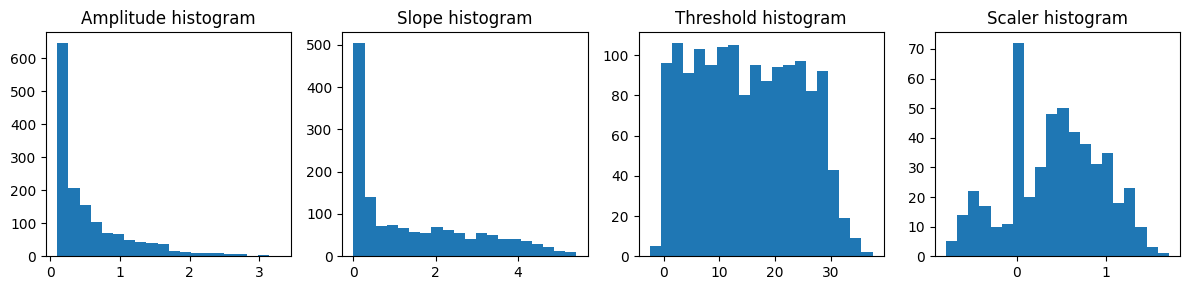

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


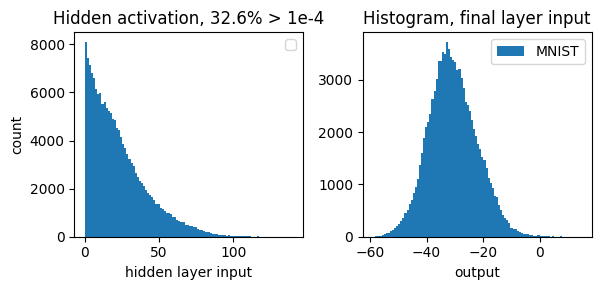

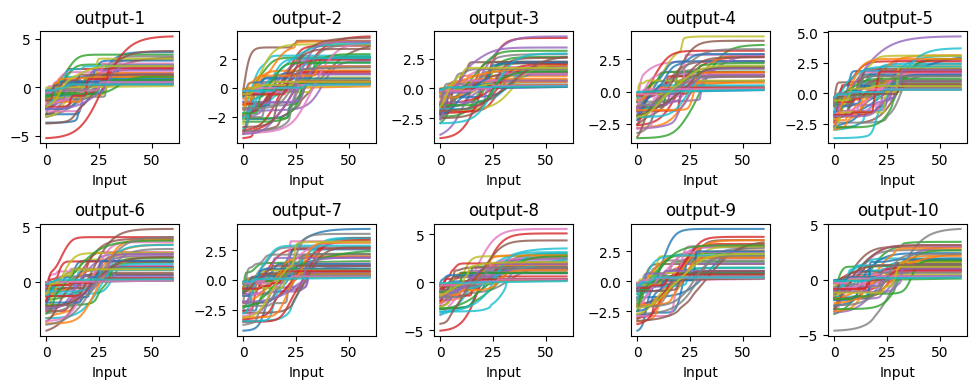

--------------------------------------------------
 Epoch 1/201, Loss: 0.4554, Accuracy: 89.71%
 Epoch 11/201, Loss: 0.1578, Accuracy: 95.71%
 Epoch 21/201, Loss: 0.1195, Accuracy: 95.95%
 Epoch 31/201, Loss: 0.1022, Accuracy: 96.92%
 Epoch 41/201, Loss: 0.0900, Accuracy: 96.78%
 Epoch 51/201, Loss: 0.0801, Accuracy: 96.56%
 Epoch 61/201, Loss: 0.0753, Accuracy: 97.13%
 Epoch 71/201, Loss: 0.0701, Accuracy: 97.10%
 Epoch 81/201, Loss: 0.0661, Accuracy: 97.34%
 Epoch 91/201, Loss: 0.0607, Accuracy: 97.38%
 Epoch 101/201, Loss: 0.0611, Accuracy: 97.38%
 Epoch 111/201, Loss: 0.0591, Accuracy: 97.34%
 Epoch 121/201, Loss: 0.0564, Accuracy: 97.09%
 Epoch 131/201, Loss: 0.0542, Accuracy: 96.93%
 Epoch 141/201, Loss: 0.0559, Accuracy: 97.20%
 Epoch 151/201, Loss: 0.0530, Accuracy: 97.28%
 Epoch 161/201, Loss: 0.0532, Accuracy: 97.60%
 Epoch 171/201, Loss: 0.0506, Accuracy: 97.43%
 Epoch 181/201, Loss: 0.0502, Accuracy: 97.16%
 Epoch 191/201, Loss: 0.0502, Accuracy: 97.37%
 Epoch 201/201, Loss

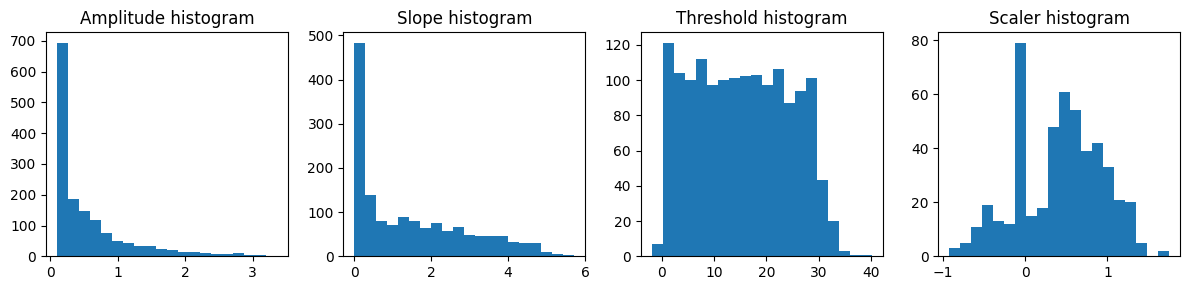

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


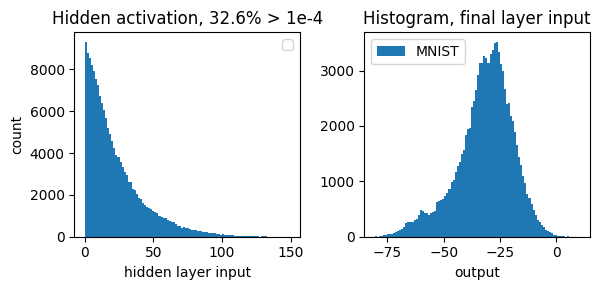

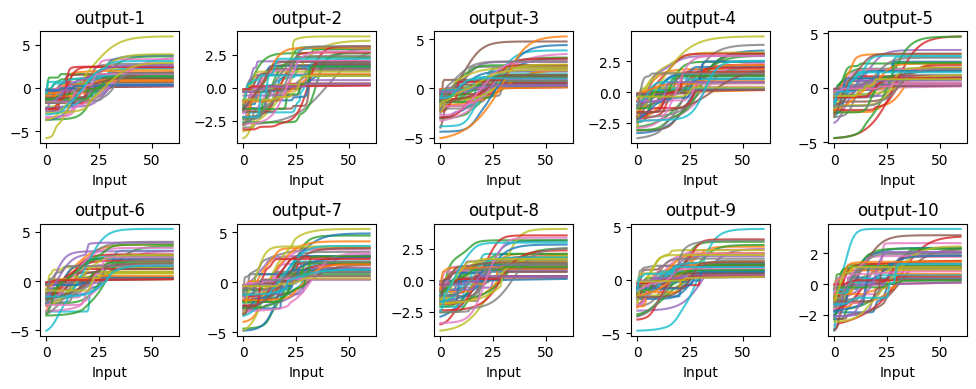

--------------------------------------------------
 Epoch 1/201, Loss: 0.4669, Accuracy: 91.37%
 Epoch 11/201, Loss: 0.1538, Accuracy: 95.84%
 Epoch 21/201, Loss: 0.1099, Accuracy: 96.51%
 Epoch 31/201, Loss: 0.0937, Accuracy: 97.05%
 Epoch 41/201, Loss: 0.0817, Accuracy: 97.09%
 Epoch 51/201, Loss: 0.0771, Accuracy: 97.22%
 Epoch 61/201, Loss: 0.0704, Accuracy: 97.35%
 Epoch 71/201, Loss: 0.0647, Accuracy: 97.23%
 Epoch 81/201, Loss: 0.0626, Accuracy: 97.15%
 Epoch 91/201, Loss: 0.0575, Accuracy: 97.16%
 Epoch 101/201, Loss: 0.0582, Accuracy: 97.34%
 Epoch 111/201, Loss: 0.0567, Accuracy: 97.35%
 Epoch 121/201, Loss: 0.0524, Accuracy: 97.11%
 Epoch 131/201, Loss: 0.0505, Accuracy: 97.33%
 Epoch 141/201, Loss: 0.0503, Accuracy: 97.45%
 Epoch 151/201, Loss: 0.0513, Accuracy: 97.36%
 Epoch 161/201, Loss: 0.0489, Accuracy: 97.51%
 Epoch 171/201, Loss: 0.0496, Accuracy: 97.41%
 Epoch 181/201, Loss: 0.0458, Accuracy: 97.31%
 Epoch 191/201, Loss: 0.0463, Accuracy: 97.49%
 Epoch 201/201, Loss

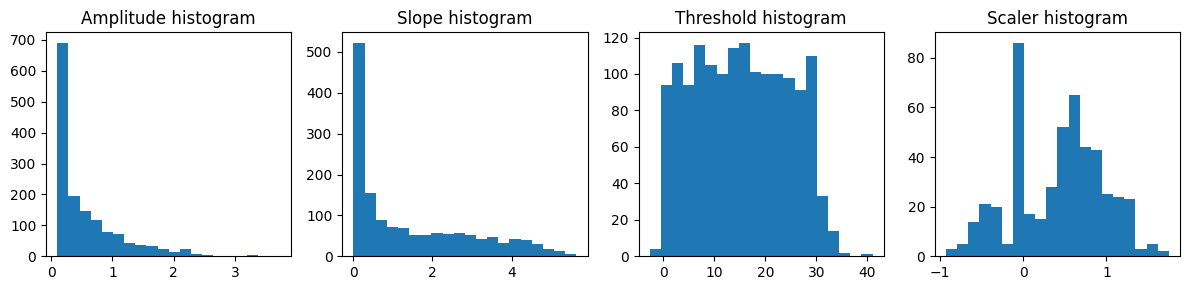

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


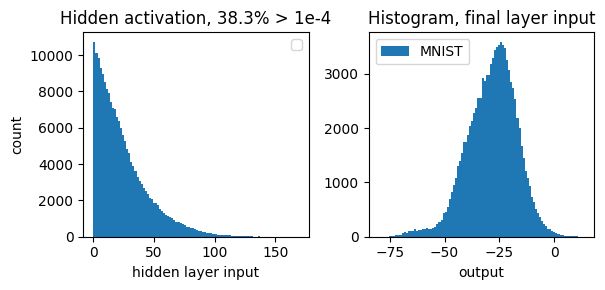

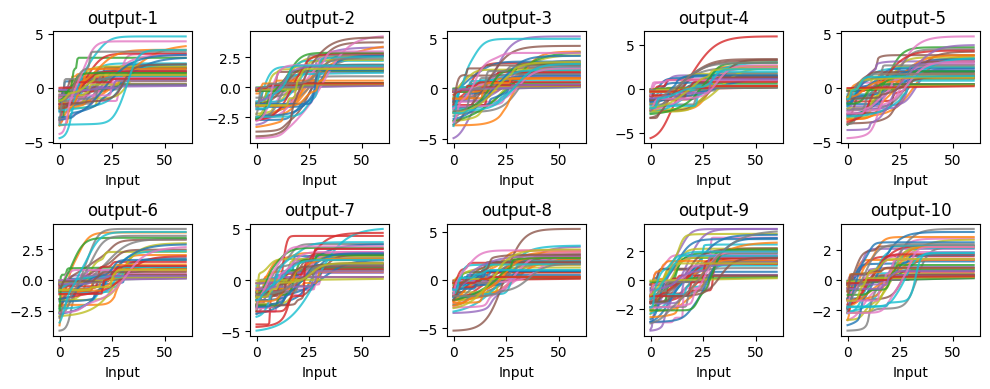

--------------------------------------------------
 Epoch 1/201, Loss: 0.4512, Accuracy: 91.07%
 Epoch 11/201, Loss: 0.1640, Accuracy: 95.31%
 Epoch 21/201, Loss: 0.1232, Accuracy: 96.30%
 Epoch 31/201, Loss: 0.1017, Accuracy: 96.52%
 Epoch 41/201, Loss: 0.0891, Accuracy: 96.98%
 Epoch 51/201, Loss: 0.0815, Accuracy: 97.24%
 Epoch 61/201, Loss: 0.0772, Accuracy: 97.15%
 Epoch 71/201, Loss: 0.0691, Accuracy: 97.16%
 Epoch 81/201, Loss: 0.0693, Accuracy: 96.91%
 Epoch 91/201, Loss: 0.0665, Accuracy: 97.17%
 Epoch 101/201, Loss: 0.0613, Accuracy: 97.29%
 Epoch 111/201, Loss: 0.0602, Accuracy: 96.70%
 Epoch 121/201, Loss: 0.0586, Accuracy: 97.25%
 Epoch 131/201, Loss: 0.0564, Accuracy: 97.16%
 Epoch 141/201, Loss: 0.0559, Accuracy: 97.24%
 Epoch 151/201, Loss: 0.0515, Accuracy: 97.35%
 Epoch 161/201, Loss: 0.0532, Accuracy: 97.29%
 Epoch 171/201, Loss: 0.0530, Accuracy: 97.34%
 Epoch 181/201, Loss: 0.0484, Accuracy: 97.35%
 Epoch 191/201, Loss: 0.0503, Accuracy: 97.03%
 Epoch 201/201, Loss

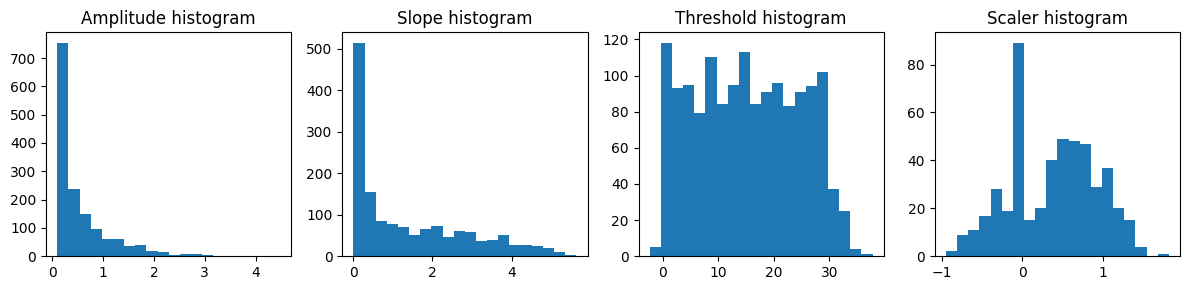

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


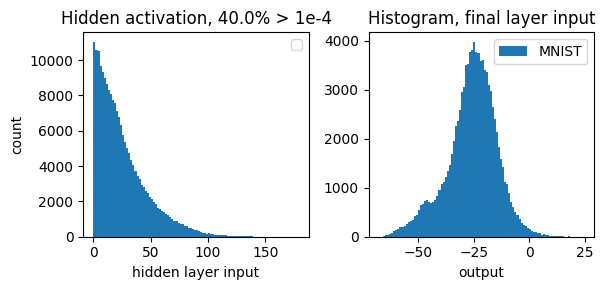

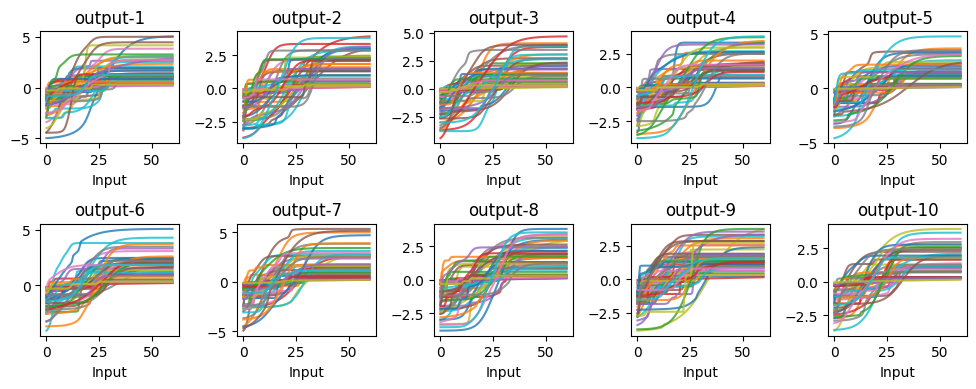

--------------------------------------------------
 Epoch 1/201, Loss: 0.4543, Accuracy: 92.27%
 Epoch 11/201, Loss: 0.1515, Accuracy: 96.21%
 Epoch 21/201, Loss: 0.1165, Accuracy: 96.63%
 Epoch 31/201, Loss: 0.1001, Accuracy: 96.75%
 Epoch 41/201, Loss: 0.0872, Accuracy: 96.99%
 Epoch 51/201, Loss: 0.0818, Accuracy: 97.10%
 Epoch 61/201, Loss: 0.0752, Accuracy: 97.31%
 Epoch 71/201, Loss: 0.0703, Accuracy: 97.21%
 Epoch 81/201, Loss: 0.0679, Accuracy: 97.28%
 Epoch 91/201, Loss: 0.0636, Accuracy: 97.36%
 Epoch 101/201, Loss: 0.0589, Accuracy: 97.35%
 Epoch 111/201, Loss: 0.0584, Accuracy: 97.40%
 Epoch 121/201, Loss: 0.0545, Accuracy: 97.59%
 Epoch 131/201, Loss: 0.0540, Accuracy: 97.45%
 Epoch 141/201, Loss: 0.0536, Accuracy: 97.42%
 Epoch 151/201, Loss: 0.0520, Accuracy: 97.41%
 Epoch 161/201, Loss: 0.0524, Accuracy: 97.51%
 Epoch 171/201, Loss: 0.0506, Accuracy: 97.52%
 Epoch 181/201, Loss: 0.0510, Accuracy: 97.55%
 Epoch 191/201, Loss: 0.0473, Accuracy: 97.54%
 Epoch 201/201, Loss

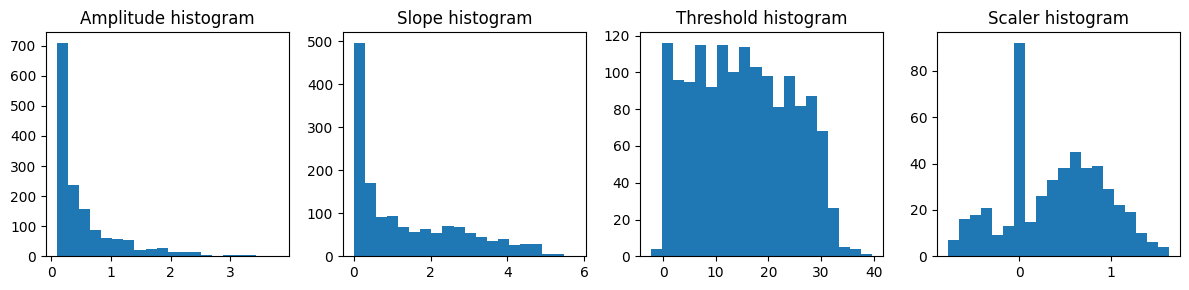

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


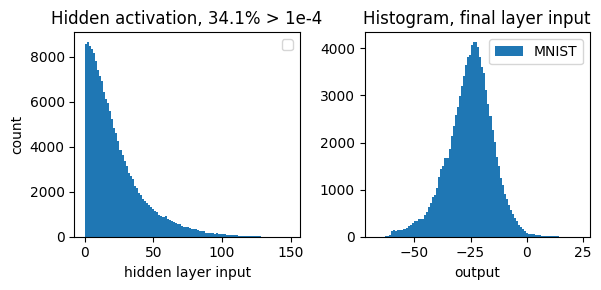

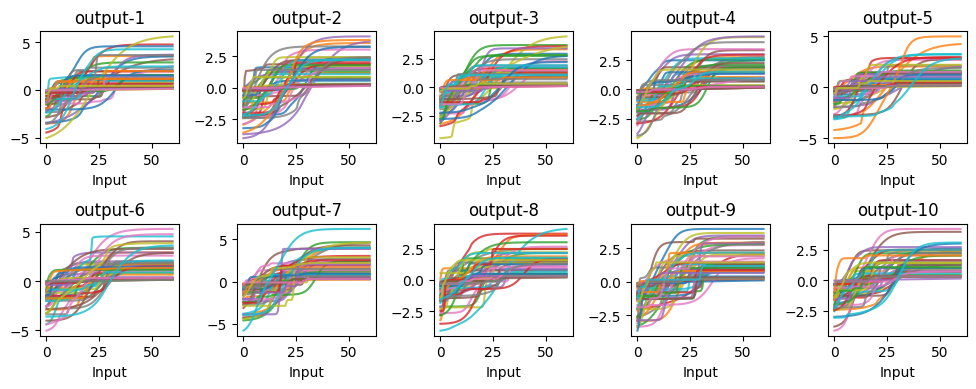

--------------------------------------------------
 Epoch 1/201, Loss: 0.4669, Accuracy: 90.99%
 Epoch 11/201, Loss: 0.1555, Accuracy: 95.35%
 Epoch 21/201, Loss: 0.1186, Accuracy: 95.87%
 Epoch 31/201, Loss: 0.1003, Accuracy: 96.74%
 Epoch 41/201, Loss: 0.0854, Accuracy: 96.90%
 Epoch 51/201, Loss: 0.0777, Accuracy: 97.22%
 Epoch 61/201, Loss: 0.0721, Accuracy: 97.28%
 Epoch 71/201, Loss: 0.0675, Accuracy: 97.16%
 Epoch 81/201, Loss: 0.0625, Accuracy: 97.16%
 Epoch 91/201, Loss: 0.0578, Accuracy: 97.19%
 Epoch 101/201, Loss: 0.0576, Accuracy: 97.27%
 Epoch 111/201, Loss: 0.0538, Accuracy: 97.16%
 Epoch 121/201, Loss: 0.0528, Accuracy: 97.59%
 Epoch 131/201, Loss: 0.0518, Accuracy: 97.46%
 Epoch 141/201, Loss: 0.0473, Accuracy: 97.40%
 Epoch 151/201, Loss: 0.0468, Accuracy: 97.47%
 Epoch 161/201, Loss: 0.0469, Accuracy: 97.56%
 Epoch 171/201, Loss: 0.0462, Accuracy: 97.36%
 Epoch 181/201, Loss: 0.0437, Accuracy: 97.41%
 Epoch 191/201, Loss: 0.0442, Accuracy: 97.69%
 Epoch 201/201, Loss

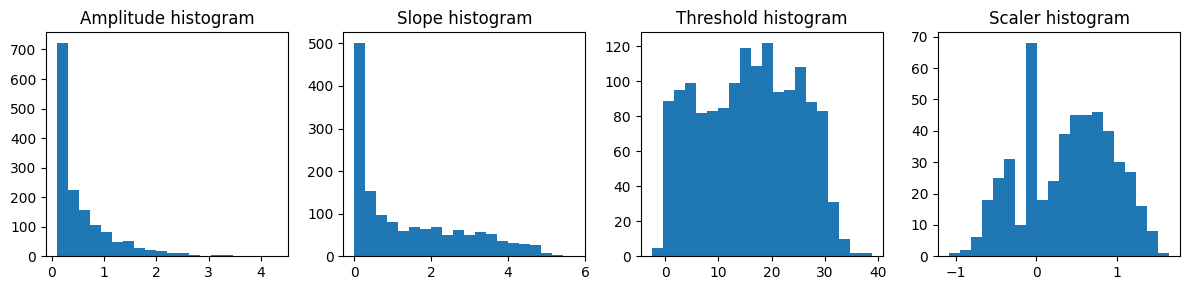

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


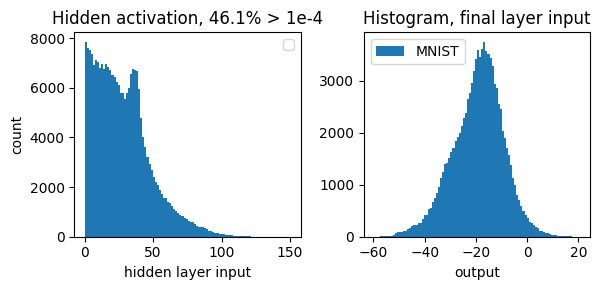

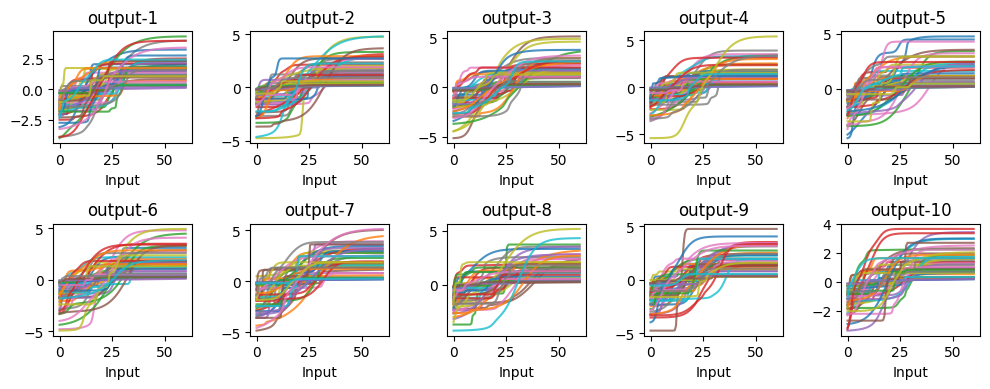

--------------------------------------------------


In [9]:
result = []
for i in range(10):
    torch.manual_seed(i)
    model = ParallelSynapse2NN(
        input_dim, 
        n_synapse, 
        hidden_dim, 
        output_dim, 
        hidden_range
    )
    result.append(train_models_NN(model, trainloader, testloader, num_epochs = 201, verbose = True, regularization=0.000))
    plot_parallel_synapse_params(model)
    plot_input_histogram_to_parallel_synapse_layer(model, testloader, hidden_act='relu')
    
    

    with open('result_parallel_softmax_H_{:d}_M_{:d}.pickle'.format(hidden_dim, n_synapse), 'wb') as f:
        pickle.dump(result, f)
    print('--------------------------------------------------')

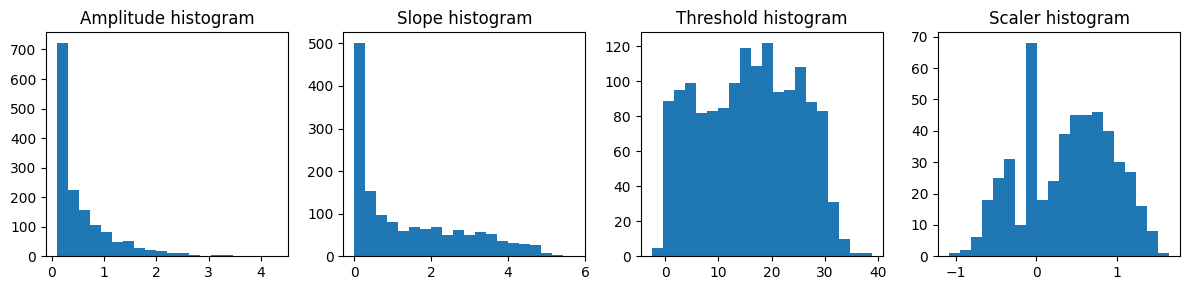

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


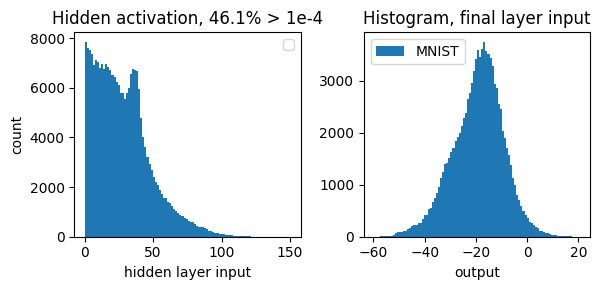

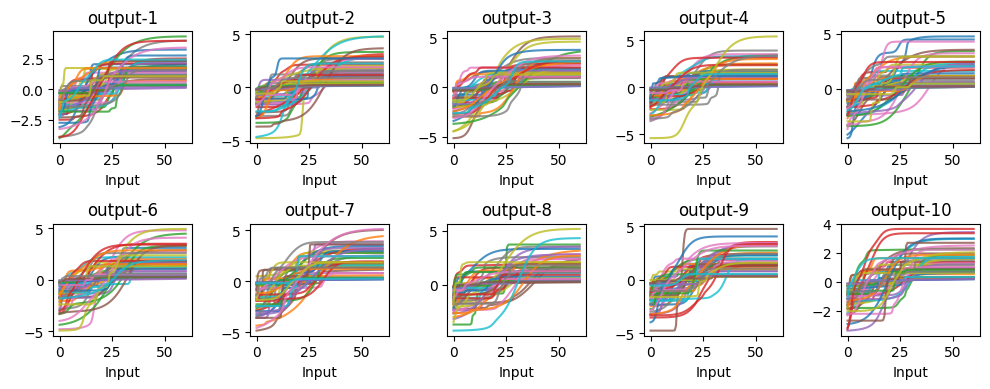

In [10]:
plot_parallel_synapse_params(model)
plot_input_histogram_to_parallel_synapse_layer(model, testloader, hidden_act='relu')
    